In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import time
import pickle

import IPython.display as ipd
import librosa
import librosa.display

from glob import glob
from dotenv import load_dotenv
from scipy.stats import norm

# Cargando la informacion

Cargar el archivo de variables de entorno

In [4]:
load_dotenv()

True

Cargar los metadatos de los audios que poseen anotaciones, además de cargar también en una lista los nombres de los archivos de audio existentes

In [5]:
AUDIO_DIR = os.getenv('PMEMO_AUDIO')
aux_dir = os.getenv('PMEMO_META')
pmemo_metadata_dir = f"{aux_dir.split('.')[0]}_total.csv"

In [6]:
#Comprobar que los archivos existan

if os.path.exists(AUDIO_DIR):
    print("El directorio de audios existe")
else:
    print("El directorio de audios no existe")
    
if os.path.exists(pmemo_metadata_dir):
    print("El archivo de metada existe")
else:
    print("El archivo de metada no existe")

El directorio de audios existe
El archivo de metada existe


In [7]:
pmemo_metadata = pd.read_csv(pmemo_metadata_dir)
pmemo_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   musicId            767 non-null    int64  
 1   fileName           767 non-null    object 
 2   title              767 non-null    object 
 3   artist             767 non-null    object 
 4   album              760 non-null    object 
 5   duration           767 non-null    float64
 6   chorus_start_time  767 non-null    object 
 7   chorus_end_time    767 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 48.1+ KB


In [8]:
audios_list = os.listdir(AUDIO_DIR)
if os.path.exists(os.path.join(AUDIO_DIR,
                               audios_list[0])):
    print(f"el archivo {audios_list[0]} existe")

el archivo 1.mp3 existe


Cuando se trabaja con anotaciones dinamicas los audios fueron segmentados en fragmentos de 0.5 segundos, pero la segmentacion toma desde el segundo 15.5 y segmenta hasta el final del clip de audio, hay clips que tienen más segementos que otros

In [9]:
pmemo_metadata.head(5)

,musicId,fileName,title,artist,album,duration,chorus_start_time,chorus_end_time
0,1,1.mp3,Good Drank,2 Chainz,"Def Jam Presents: Direct Deposit, Vol. 2",32.10,02:35,03:05
1,4,4.mp3,X Bitch (feat. Future),21 Savage,Savage Mode,28.09,03:00,03:26
2,5,5.mp3,No Heart,21 Savage,Savage Mode,84.23,00:41,02:03
3,6,6.mp3,Red Opps,21 Savage,Red Opps,29.53,02:16,02:44
4,7,7.mp3,Girls Talk Boys,5 Seconds Of Summer,Ghostbusters (Original Motion Picture Soundtrack),29.11,02:30,02:57


In [10]:
audio_files = glob(f"{AUDIO_DIR}\\*.mp3")

In [11]:
random_idx = np.random.randint(low=0,high=len(audio_files))
aux_audio_file = audio_files[random_idx].split('\\')[-1]
display(pmemo_metadata.loc[pmemo_metadata['fileName'] == aux_audio_file])

,musicId,fileName,title,artist,album,duration,chorus_start_time,chorus_end_time
462,594,594.mp3,Peek A Boo,Lil Yachty,Peek A Boo,64.17,02:48,03:50


In [12]:
ipd.Audio(audio_files[random_idx])

In [13]:
y,sr = librosa.load(audio_files[random_idx])
print(f'y:{y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y:[ 3.1832315e-12  4.6838977e-11  7.0031092e-11 -8.1854523e-12
 -2.8194336e-11 -1.3869794e-11  1.8189894e-11 -3.0922820e-11
 -7.2759576e-12 -3.9108272e-11]
shape y: (1411776,)
sr: 22050


In [14]:
pd.Series(y)

0          3.183231e-12
1          4.683898e-11
2          7.003109e-11
3         -8.185452e-12
4         -2.819434e-11
               ...     
1411771    1.623258e-04
1411772   -2.522357e-04
1411773    4.517697e-04
1411774   -1.459569e-05
1411775    1.595467e-04
Length: 1411776, dtype: float32

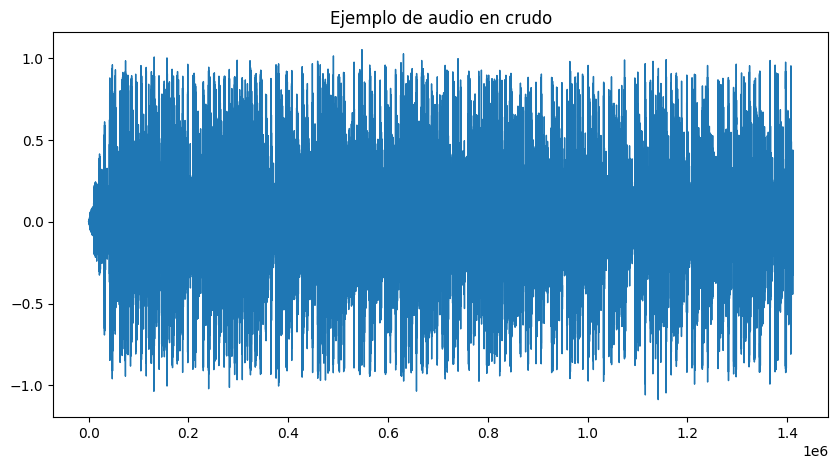

In [15]:
pd.Series(y).plot(figsize=(10,5),
                  lw=1,
                  title='Ejemplo de audio en crudo')
plt.show()

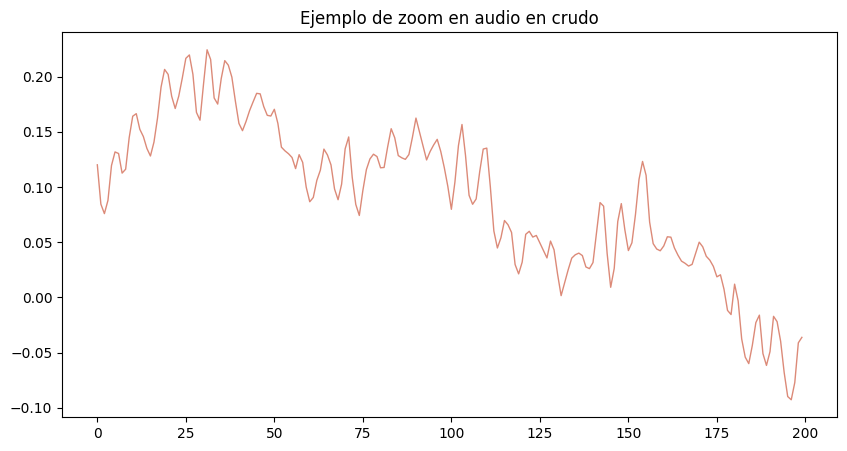

In [16]:
pd.Series(y[20000:20200]).plot(figsize=(10,5),
                             lw=1,
                             title= 'Ejemplo de zoom en audio en crudo',
                             color='#dc8a78')
plt.show()

Espectrogramas

In [17]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D),ref=np.max)
S_db.shape

(1025, 2758)

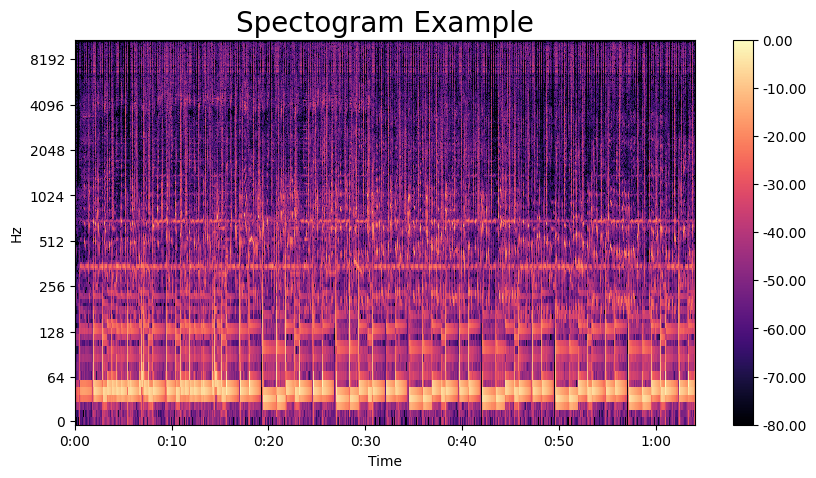

In [18]:
fig, ax = plt.subplots(figsize = (10,5))

img = librosa.display.specshow(S_db,
                               x_axis='time',
                               y_axis='log',
                               ax=ax)
ax.set_title('Spectogram Example', fontsize = (20))
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

# Espectrogramas de los archivos de audio

In [18]:
aux_filenames = pmemo_metadata['fileName']
filenames = [os.path.join(AUDIO_DIR,aux_filenames[i]) for i in range(len(aux_filenames))]

print(filenames[0])
print(audio_files[0])

E:\python_proy\mer\assets\PMEMO\PMEmo2019\chorus\1.mp3
E:\python_proy\mer\assets\PMEMO\PMEmo2019\chorus\1.mp3


In [19]:
# Lista para almacenar los espectrogramas
spectrograms = []

start_time = time.time()

# Generar y almacenar los espectrogramas
for audio_file in filenames:
    y, sr = librosa.load(audio_file)
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    spectrograms.append(S_db)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Tiempo total para generar los espectrogramas: {elapsed_time:.2f} segundos")

Tiempo total para generar los espectrogramas: 133.57 segundos


In [20]:
# Guardar la lista de espectrogramas usando pickle
with open('spectrograms.pkl', 'wb') as f:
    pickle.dump(spectrograms, f)

print("Espectrogramas guardados exitosamente.")

Espectrogramas guardados exitosamente.


# Cargar espectogramas desde un archivo pickle

## Cargar información

In [19]:
ASSETS_DIR = os.getenv('ASSETS_DIR')
spect_file = 'spectrograms.pkl'
spect_dir = os.path.join(ASSETS_DIR,spect_file)

#Comprobar que existe el archivo

if os.path.exists(spect_dir):
    print('Todo bien')
else:
    print('El arhicvo de espectogramas no existe')

Todo bien


In [23]:
with open (spect_dir,'rb') as f:
    spectrograms = pickle.load(f)
    
print(type(spectrograms))

<class 'list'>


In [26]:
print(len(spectrograms))
print(type(spectrograms[0]))

767
<class 'numpy.ndarray'>


In [27]:
spec_size = [s.shape[1] for s in spectrograms]
spec_mean = np.mean(spec_size)
spec_std = np.std(spec_size)

print(f'Duracion media: {spec_mean}')
print(f'Duración desviación: {spec_std}')
print(f'Alto: {np.max(spec_size)}')
print(f'Bajo: {np.min(spec_size)}')

Duracion media: 1671.0691003911343
Duración desviación: 586.9379508923892
Alto: 3792
Bajo: 691


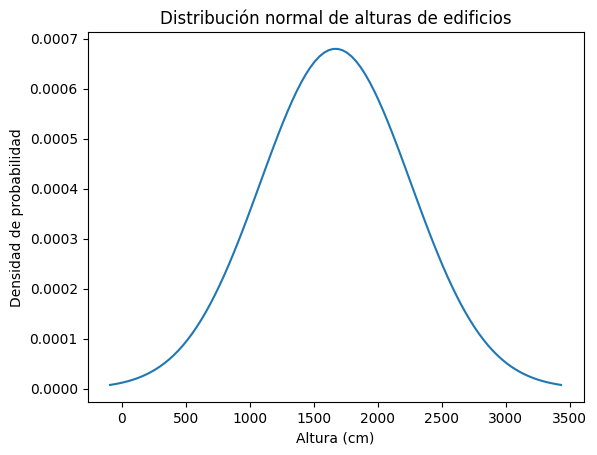

In [32]:
x = np.linspace(spec_mean - 3*spec_std,
                spec_mean + 3*spec_std,
                100)

y = norm.pdf(x,spec_mean,spec_std)


# Crea la gráfica de campana de Gauss

plt.plot(x, y)

plt.xlabel('Altura (cm)')

plt.ylabel('Densidad de probabilidad')

plt.title('Distribución normal de alturas de edificios')

plt.show()

## Mostrar espectrogramas

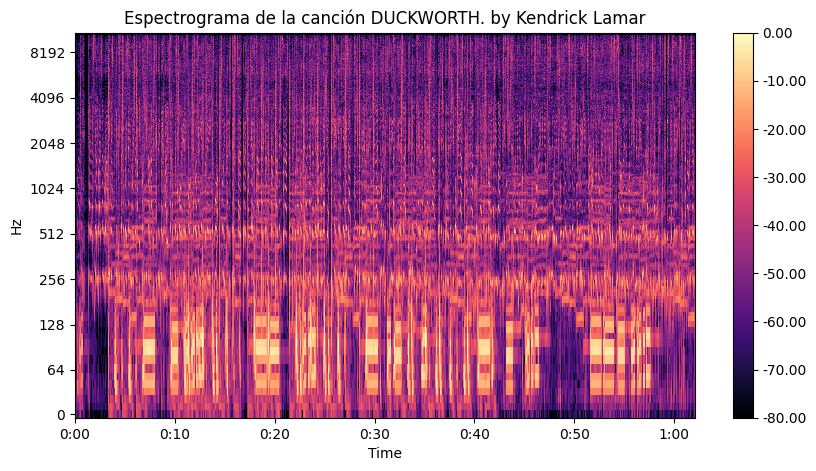

Dimensión: (1025, 2672)


In [119]:
current_indx = np.random.randint(0,
                                 len(pmemo_metadata) - 1)

current_song = pmemo_metadata.iloc[current_indx]

current_spec = spectrograms [current_indx]
fig,ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(current_spec,
                               x_axis='time',
                               y_axis='log',
                               ax=ax)
ax.set_title(f'Espectrograma de la canción {current_song[2]} by {current_song[3]}')
fig.colorbar(img,ax=ax,format=f'%0.2f')

plt.show()

print(f'Dimensión: {current_spec.shape}')

In [107]:
def ajustar_spectogram(spectogram,target_len):
    """
    Ajusta el espectrograma a la longitud deseada.
    Si es más largo, lo recorta. Si es más corto, aplica padding.
    
    Args:
        spectrogram (np.array): Espectrograma de dimensiones (frecuencias, tiempo).
        target_len (int): Longitud deseada para la dimensión de tiempo.

    Returns:
        np.array: Espectrograma ajustado con padding o recorte.
    """
    current_len = spectogram.shape[1]
    
    #Si el espectograma es mayor que el tamaño deseado, recortar
    adjusted_spectrogram = librosa.util.fix_length(spectogram, size=target_len)
    
    return adjusted_spectrogram
    

In [110]:
aux = spectrograms[1]
print(aux.shape)

print(type(np.max(spec_size)))

adjusted_aux = ajustar_spectogram(aux,np.max(spec_size))

print(adjusted_aux.shape)

(1025, 1208)
<class 'numpy.int32'>
(1025, 3792)


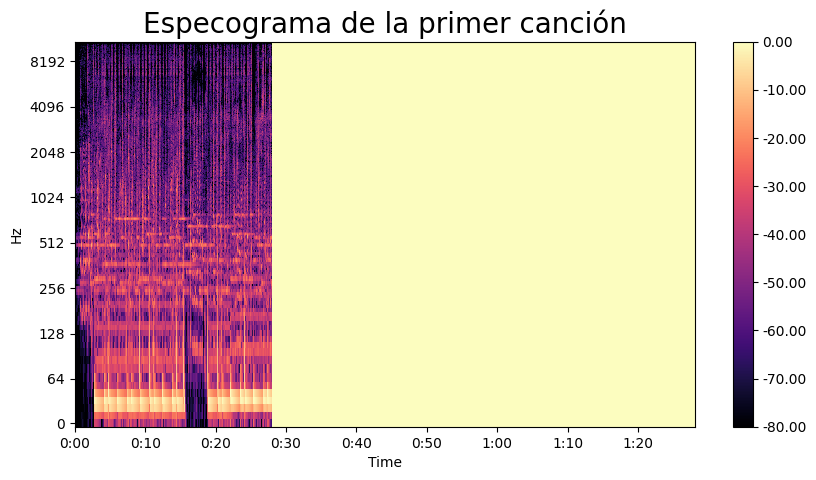

In [111]:
fig,ax = plt.subplots(figsize = (10,5))

img = librosa.display.specshow(adjusted_aux,
                               x_axis = 'time',
                               y_axis = 'log',
                               ax = ax)

ax.set_title('Especograma de la primer canción',fontsize=(20))
fig.colorbar(img,ax=ax,format=f'%0.2f')

plt.show()

## Guardar espectrogramas ajustados

In [115]:
padded_spec = []
start_time = time.time()
for s in spectrograms:
    aux = ajustar_spectogram(s,int(spec_mean))
    padded_spec.append(aux)
    
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Tiempo total para paddear los espectrogramas: {elapsed_time:.2f} segundos")

Tiempo total para paddear los espectrogramas: 10.35 segundos


In [116]:
PADDED_DIR = os.path.join(ASSETS_DIR,'padded_spectrograms.pkl')

# Guardar la lista de espectrogramas usando pickle
with open(PADDED_DIR, 'wb') as f:
    pickle.dump(padded_spec, f)

print("Espectrogramas guardados exitosamente.")

Espectrogramas guardados exitosamente.


cargar los archivos

In [117]:
with open (PADDED_DIR,'rb') as f:
    padded_spec = pickle.load(f)

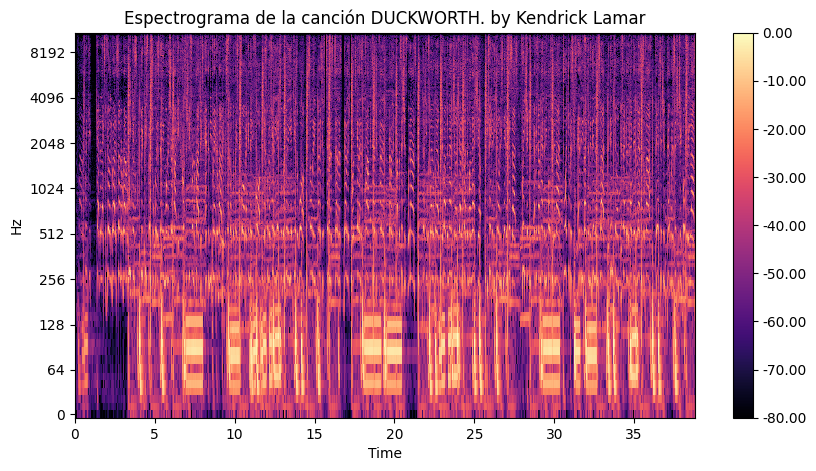

Dimensión: (1025, 1671)


In [120]:
current_song = pmemo_metadata.iloc[current_indx]

current_spec = padded_spec [current_indx]
fig,ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(current_spec,
                               x_axis='time',
                               y_axis='log',
                               ax=ax)
ax.set_title(f'Espectrograma de la canción {current_song[2]} by {current_song[3]}')
fig.colorbar(img,ax=ax,format=f'%0.2f')

plt.show()

print(f'Dimensión: {current_spec.shape}')